1、数据预处理（15 分）

In [60]:
import pandas as pd
import time
# 加载数据
df = pd.read_csv('sales_details.csv',encoding='gbk')

# 检查缺失值
missing_values = df.isnull().sum()
print(missing_values)
# 删除缺失值
df = df.dropna()
# print(df.head())

创建日期      1
物料编号      1
应发库       1
销售订单数量    1
交货数量      1
dtype: int64


In [61]:
# 统计应发库列中每个城市的数量，并按数量降序排序
city_counts = df['应发库'].value_counts()

# 选择前9个城市作为正常值
normal_cities = city_counts.head(9).index.tolist()
# print(normal_cities)

# 删除不在城市列表中的数据
df = df[df['应发库'].isin(normal_cities)]


In [62]:
# 移除千位分隔符，并将字符串转换为浮点数再转换为整数
df['销售订单数量'] = df['销售订单数量'].str.replace(',', '').astype(float).astype(int)
df['交货数量'] = df['交货数量'].str.replace(',', '').astype(float).astype(int)



In [63]:
# 转换日期格式并提取年份和月份
df['创建日期'] = pd.to_datetime(df['创建日期'], format='%Y.%m.%d')
df['创建年'] = df['创建日期'].dt.year
df['创建月'] = df['创建日期'].dt.month
print(df.head())


        创建日期         物料编号 应发库  销售订单数量  交货数量   创建年  创建月
0 2013-05-30  10482258-00  sz      60    60  2013    5
1 2013-05-30  10261297-00  sz       3     3  2013    5
2 2013-05-30  10134443-00  jn      50    50  2013    5
3 2013-05-30  10195108-00  jn      20    20  2013    5
4 2013-05-30  10261297-00  jn       1     1  2013    5


In [64]:
from sklearn.preprocessing import LabelEncoder

# 编码物料编号和应发库
label_encoder_物料编号 = LabelEncoder()
label_encoder_应发库 = LabelEncoder()
df['物料编号'] = label_encoder_物料编号.fit_transform(df['物料编号'])
df['应发库'] = label_encoder_应发库.fit_transform(df['应发库'])
print(df.head())


        创建日期  物料编号  应发库  销售订单数量  交货数量   创建年  创建月
0 2013-05-30    33    7      60    60  2013    5
1 2013-05-30    25    7       3     3  2013    5
2 2013-05-30     2    3      50    50  2013    5
3 2013-05-30    15    3      20    20  2013    5
4 2013-05-30    25    3       1     1  2013    5


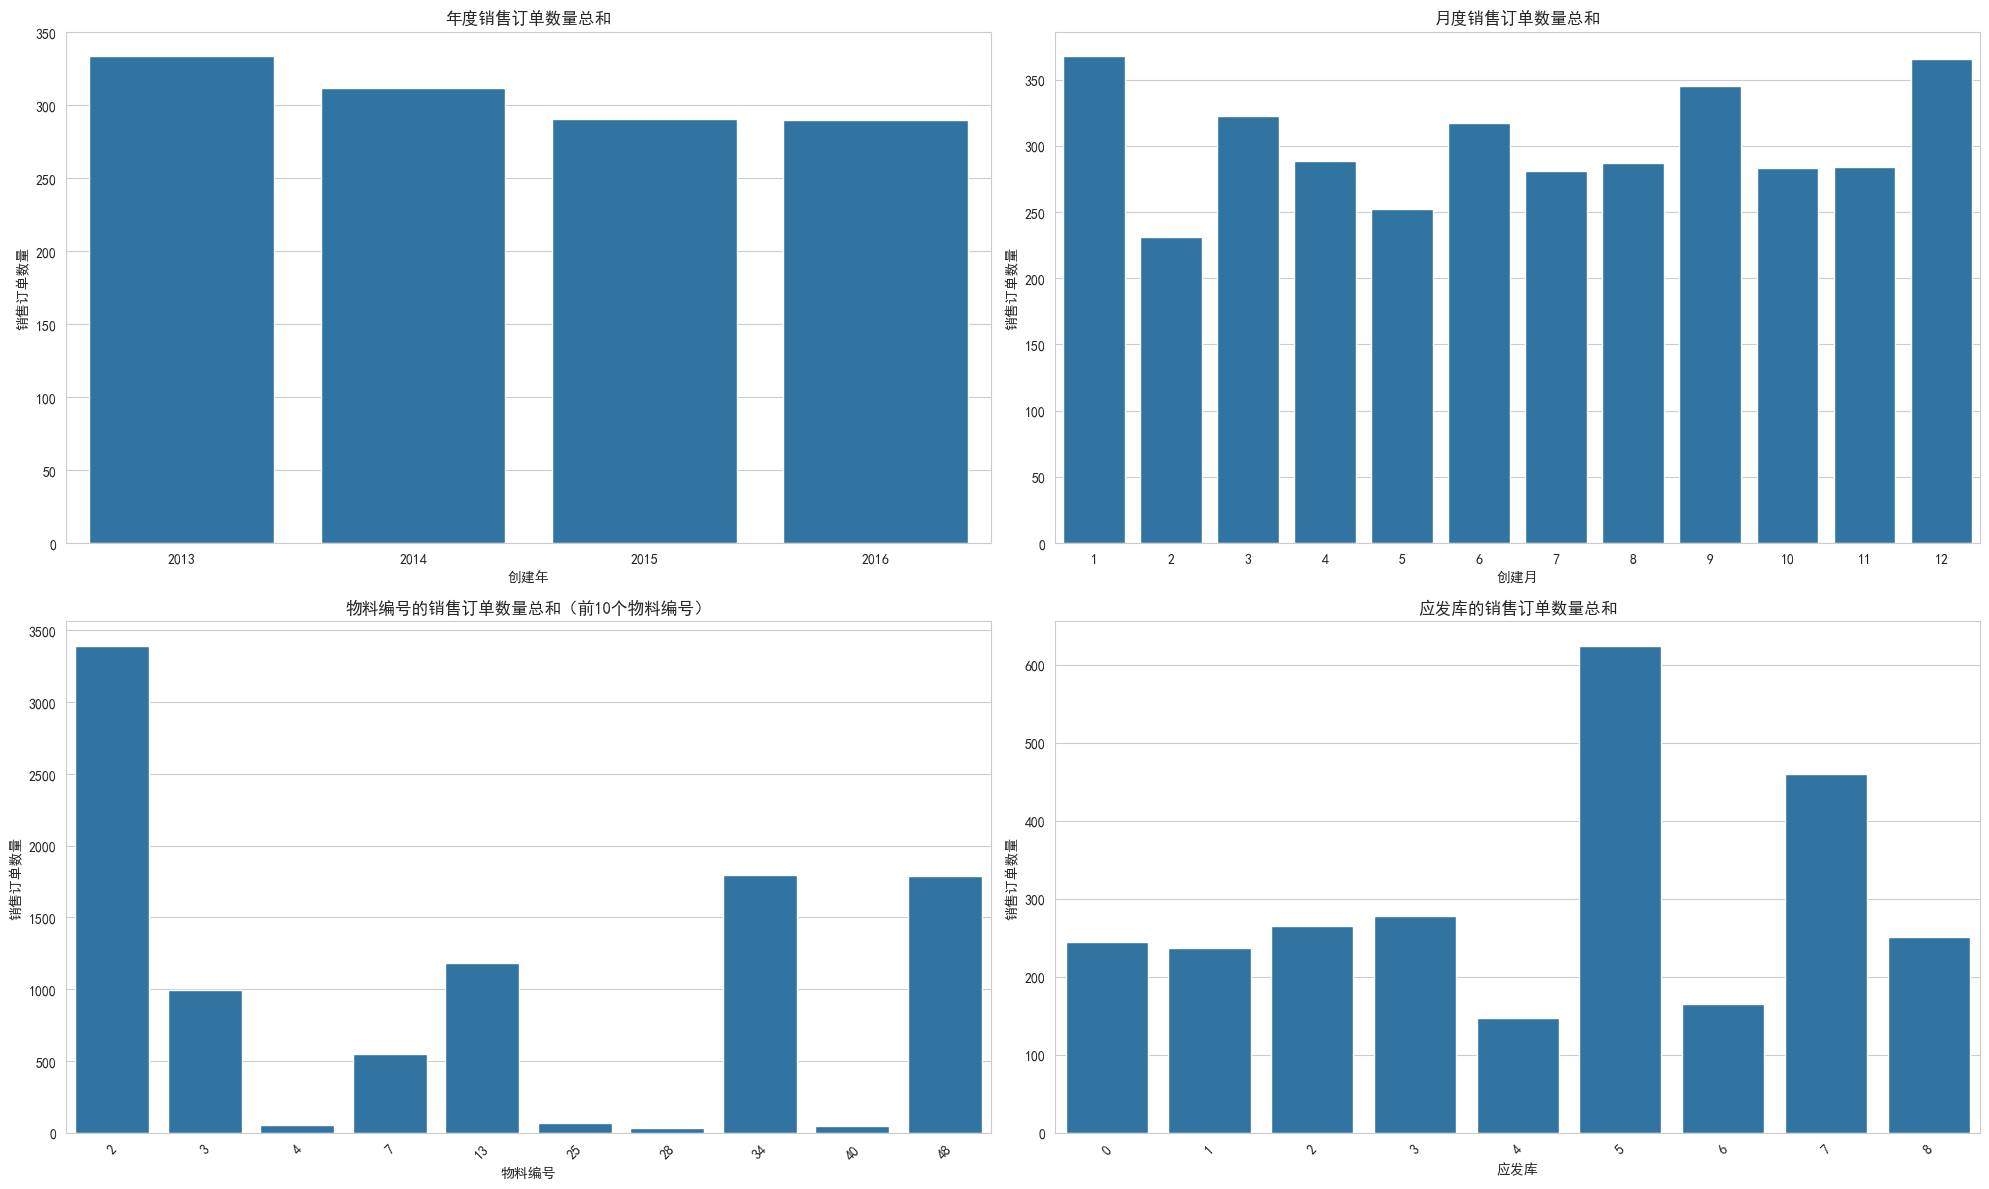

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 假设你的数据 DataFrame 已经按要求分组并求和
grouped_df = df.groupby(['创建年', '创建月', '物料编号', '应发库'])['销售订单数量'].sum().reset_index()

# 设置图形大小和子图布局
fig,axes=plt.subplots(2,2,figsize=(20,12))

# 1. 按年展示销售订单数量总和
sns.barplot(data=grouped_df,x='创建年',y='销售订单数量',errorbar=None,ax=axes[0,0])
axes[0,0].set_title('年度销售订单数量总和')
axes[0,0].set_xlabel('创建年')
axes[0,0].set_ylabel('销售订单数量')

# 2. 按月展示销售订单数量总和
sns.barplot(data=grouped_df,x='创建月',y='销售订单数量',errorbar=None,ax=axes[0,1])
axes[0,1].set_title('月度销售订单数量总和')
axes[0,1].set_xlabel('创建月')
axes[0,1].set_ylabel('销售订单数量')

# 3. 按物料编号展示销售订单数量总和
top_materials=grouped_df['物料编号'].value_counts().nlargest(10).index
filtered_materials_df=grouped_df[grouped_df['物料编号'].isin(top_materials)]
sns.barplot(data=filtered_materials_df,x='物料编号',y='销售订单数量',errorbar=None,ax=axes[1,0])
axes[1,0].set_title('物料编号的销售订单数量总和（前10个物料编号）')
axes[1,0].set_xlabel('物料编号')
axes[1,0].set_ylabel('销售订单数量')
axes[1,0].tick_params(axis='x',rotation=45)

# 4. 按应发库展示销售订单数量总和
sns.barplot(data=grouped_df,x='应发库',y='销售订单数量',errorbar=None,ax=axes[1,1])
axes[1,1].set_title('应发库的销售订单数量总和')
axes[1,1].set_xlabel('应发库')
axes[1,1].set_ylabel('销售订单数量')
axes[1,1].tick_params(axis='x',rotation=45)

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()


2. 构建数据集（5 分）

In [66]:
import numpy as np

# 随机打乱数据集
# print(grouped_df)
shuffled_indices = np.random.RandomState(seed=15).permutation(len(grouped_df))
# print(shuffled_indices)
df_new = grouped_df.iloc[shuffled_indices]


In [67]:
from sklearn.model_selection import train_test_split

# 分离特征和目标变量
X = df_new[['创建年', '创建月', '物料编号', '应发库']]
y = df_new['销售订单数量']

# 划分数据集
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=15)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.67, random_state=15)


3、模型训练（10 分）

In [68]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

best_depth = 0
best_score = float('inf')

# 测试不同深度的决策树
for depth in range(2, 16):
    model = DecisionTreeRegressor(max_depth=depth, random_state=15)
    model.fit(X_train, y_train)
    val_predictions = model.predict(X_val)
    val_score = mean_squared_error(y_val, val_predictions)
    
    if val_score < best_score:
        best_score = val_score
        best_depth = depth

# 训练最佳模型
best_model = DecisionTreeRegressor(max_depth=best_depth, random_state=15)
best_model.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=15, random_state=15)

In [69]:
# 测试模型
test_predictions = best_model.predict(X_test)
test_score = mean_squared_error(y_test, test_predictions)
print(f'Test MSE: {test_score}')


Test MSE: 129991.19308856825


In [70]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

# 随机森林回归模型
# 定义超参数网格
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 创建随机森林模型
rf_model = RandomForestRegressor(random_state=15)

# 使用 GridSearchCV 来搜索最佳超参数
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, scoring='neg_mean_squared_error')

# 在训练集上拟合
grid_search.fit(X_train, y_train)

# 输出最佳超参数
print(f'Best parameters found: {grid_search.best_params_}')

# 使用验证集来评估模型性能
best_rf_model = grid_search.best_estimator_
val_predictions = best_rf_model.predict(X_val)
val_mse = mean_squared_error(y_val, val_predictions)

print(f'Validation MSE: {val_mse}')

# 使用测试集来评估最终模型性能
test_predictions = best_rf_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_predictions)

print(f'Random Forest Test MSE: {test_mse}')


Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Validation MSE: 75821.40516877899
Random Forest Test MSE: 83566.41156598009


4、时间序列分析（5 分） 

In [71]:
# 按年月分组求和
monthly_sales = df.groupby(['创建年', '创建月'])['销售订单数量'].sum().reset_index()


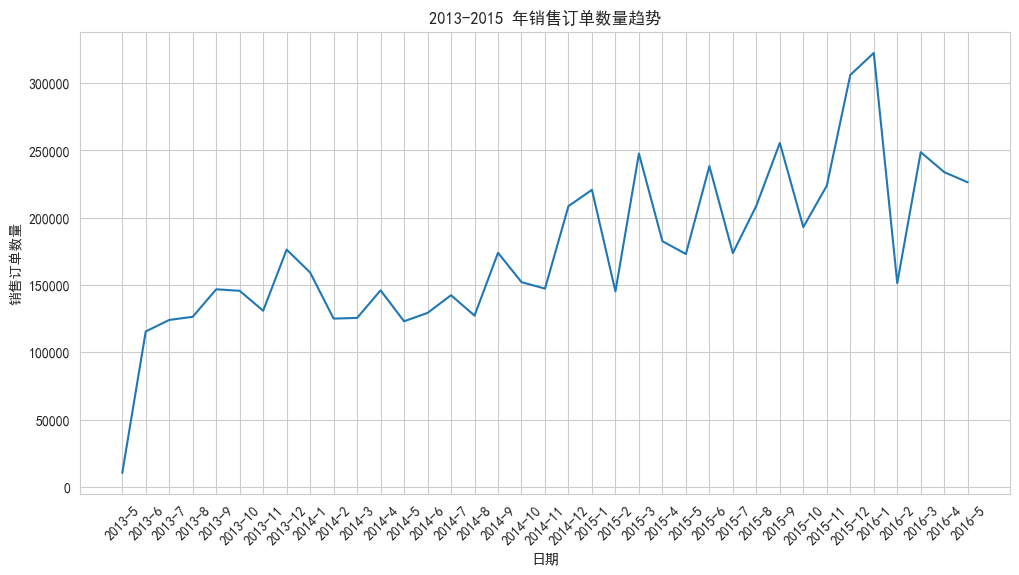

In [72]:
import matplotlib.pyplot as plt
import pandas as pd


# Fix the font issues
plt.rcParams['font.sans-serif'] = ['SimHei']  # Set the font to SimHei
plt.rcParams['axes.unicode_minus'] = False    # Ensure that negative signs are rendered correctly

# Plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['创建年'].astype(str) + '-' + monthly_sales['创建月'].astype(str), monthly_sales['销售订单数量'])
plt.xlabel('日期')
plt.ylabel('销售订单数量')
plt.title('2013-2015 年销售订单数量趋势')
plt.xticks(rotation=45)
plt.show()


5、聚类（10 分）

In [73]:
# 转换为数组
data_array = df.drop(['创建日期'], axis=1).values
# print(data_array)
print(df.drop(['创建日期'], axis=1))

        物料编号  应发库  销售订单数量  交货数量   创建年  创建月
0         33    7      60    60  2013    5
1         25    7       3     3  2013    5
2          2    3      50    50  2013    5
3         15    3      20    20  2013    5
4         25    3       1     1  2013    5
...      ...  ...     ...   ...   ...  ...
423209    98    5       5     5  2015   12
423210    98    8       1     1  2015   12
423211    98    4       3     3  2015   12
423212    69    7       1     1  2016    1
423213    98    0       1     1  2016    1

[422870 rows x 6 columns]


In [74]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode

# 如果数据较大，可以只取前10000条数据进行分析
data_array = data_array[:10000]

# 测试不同聚类个数
silhouette_scores = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=15, n_init='auto')
    kmeans.fit(data_array)
    score = silhouette_score(data_array, kmeans.labels_)
    silhouette_scores[k] = score
    # print(f'Clusters: {k}, Silhouette Score: {score}')

# 找到轮廓系数最高的聚类数量
optimal_clusters = max(silhouette_scores, key=silhouette_scores.get)
print(f'Optimal number of clusters: {optimal_clusters}')




Optimal number of clusters: 2


In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import mode


# 获取特征名和数据，排除“创建日期”
features = df.drop(['创建日期'], axis=1).columns

# 使用最优聚类数量进行聚类分析
kmeans = KMeans(n_clusters=optimal_clusters, random_state=15, n_init='auto')
kmeans.fit(data_array)

# 获取每个点的标签
labels = kmeans.labels_

# 获取聚类中心点
centers = kmeans.cluster_centers_

# 将centers的编码特征进行逆向变换
centers_df = pd.DataFrame(centers, columns=['物料编号', '应发库', '销售订单数量', '交货数量', '创建年','创建月'])

# 逆向变换编码的特征
centers_df['物料编号'] = label_encoder_物料编号.inverse_transform(centers_df['物料编号'].astype(int))
centers_df['应发库'] = label_encoder_应发库.inverse_transform(centers_df['应发库'].astype(int))
centers_df['创建年']=centers_df['创建年'].astype(int)
centers_df['创建月']=centers_df['创建月'].astype(int)
centers_df['销售订单数量']=centers_df['销售订单数量'].astype(int)
centers_df['交货数量']=centers_df['交货数量'].astype(int)
# 打印聚类中心点
print(f'Cluster Centers:\n{centers_df}')

# 计算每个聚类中心点的标签
center_labels = np.zeros(optimal_clusters, dtype=int)
for i in range(optimal_clusters):
    cluster_points_labels = labels[labels == i]
    if len(cluster_points_labels) > 0:
        center_mode = mode(cluster_points_labels, keepdims=True)
        center_labels[i] = center_mode.mode[0]
    else:
        center_labels[i] = -1  # 如果没有点属于这个中心点，给一个默认标签

print(f'Cluster Center Labels:\n{center_labels}')
# 调用函数进行绘图


Cluster Centers:
          物料编号 应发库  销售订单数量  交货数量   创建年  创建月
0  10261297-00  km      11    11  2013    6
1  10185870-00  km      66    66  2013    6
Cluster Center Labels:
[0 1]


Clusters: 2, Silhouette Score: 0.6209883156385774
Clusters: 3, Silhouette Score: 0.3879587717152359
Clusters: 4, Silhouette Score: 0.42799329022218296
Clusters: 5, Silhouette Score: 0.43211966855633765
Clusters: 6, Silhouette Score: 0.43557319514376275
Clusters: 7, Silhouette Score: 0.4487943554900214
Clusters: 8, Silhouette Score: 0.46569792663810233
Clusters: 9, Silhouette Score: 0.45793840306305145
Clusters: 10, Silhouette Score: 0.45904861829821375


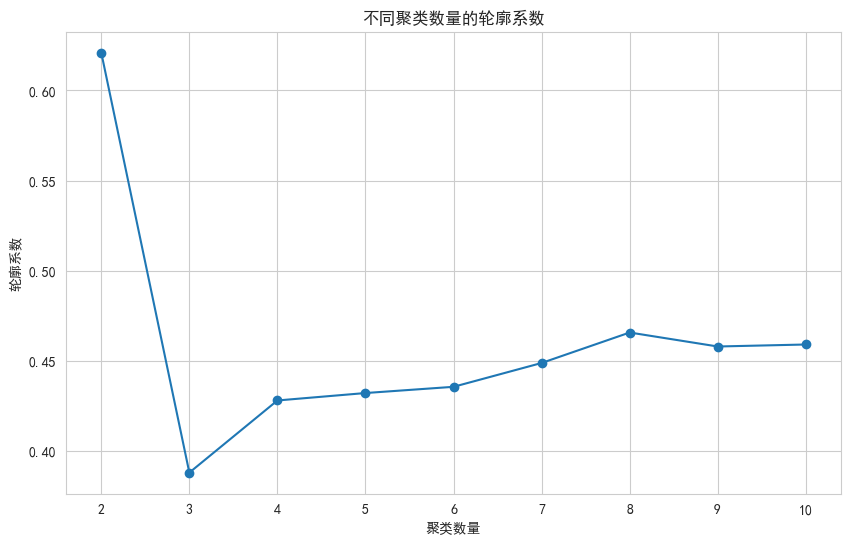

In [76]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd

# 将 numpy 数组转换为 pandas DataFrame
data_array_df = pd.DataFrame(data_array)
scores = {}
# 测试不同聚类个数
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=15,n_init='auto')
    kmeans.fit(data_array)
    score = silhouette_score(data_array, kmeans.labels_)
    scores[k]=score
    print(f'Clusters: {k}, Silhouette Score: {score}')
plt.figure(figsize=(10, 6))
plt.plot(list(scores.keys()), list(scores.values()), marker='o')
plt.title('不同聚类数量的轮廓系数')
plt.xlabel('聚类数量')
plt.ylabel('轮廓系数')
plt.grid(True)
plt.show()

